In [2]:
from bs4 import BeautifulSoup
import bs4
import requests
import requests_cache
import re
import pandas as pd
import seaborn as sns

requests_cache.install_cache("bases_scraping", expire_after=10e5)

In [30]:
# On désactive les écritures scientifiques
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [31]:
prices = []
surfaces = []
types = []
pieces = []
cps = []
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'
}

In [32]:
url = f"https://www.paruvendu.fr/immobilier/annonceimmofo/liste/listeAnnonces?tt=1&tbApp=1&tbDup=1&tbChb=1&tbLof=1&tbAtl=1&tbPla=1&tbMai=1&tbVil=1&tbCha=1&tbPro=1&tbHot=1&tbMou=1&tbFer=1&at=1&pa=FR&lol=0&ray=50&codeINSEE=35XX0,"
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

In [33]:
def get_nb_pages():
    string = soup.find("div", class_="resume").span.text
    a = int(string.split("-")[0])
    b = int(string.split("-")[1].split("sur")[0])
    c = int(string.split("-")[1].split("sur")[1].replace("annonces",""))    
    return c // (b-a)

nb_pages = get_nb_pages()
nb_pages

15

In [34]:
for i in range(1,nb_pages+1):
    url = f"https://www.paruvendu.fr/immobilier/annonceimmofo/liste/listeAnnonces?tt=1&tbApp=1&tbDup=1&tbChb=1&tbLof=1&tbAtl=1&tbPla=1&tbMai=1&tbVil=1&tbCha=1&tbPro=1&tbHot=1&tbMou=1&tbFer=1&at=1&pa=FR&lol=0&ray=50&codeINSEE=35XX0,,&p={i}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    
    for annonce in soup.find_all('div', class_="ergov3-annonce"):
        # prix du bien
        price = annonce.find('div', class_="ergov3-priceannonce")
        price = int(price.text.replace(" ","").replace("€","").replace("\n","").replace("*","").replace("\r",""))
        #print(re.sub(r'(\s+){2,}|(\*)', ' ', annonce.find('div', class_='ergov3-priceannonce').text))

        # Titre de l'annonce. Permet de déduire le nombre de pièce, la surface et le type de bien
        txt = annonce.find('div', class_="ergov3-txtannonce")
        #print(re.sub(r"""[!?'".<>(){}@%&*/[/]""", " ",txt.h3.text ))
        # type de bien
        type_bien = txt.h3.text.split('\r\n')[1]

        # nombre de pièce du bien
        nb_pieces = txt.h3.text.split('\r\n')[2]

        # surface du bien
        surface = txt.h3.span.text.split(",")[-1].split("-")[-1].replace("m²","").replace(" ","").replace("\t","").replace("\n","").replace("\r","").replace("carrez","")

        # Code postal de l'annonce
        #cp = txt.cite.text.replace("(","").replace(")","").split(' ')[1].replace("\t","").replace("\n","").replace("\r","")
        cp = re.sub(r'\r\n','',txt.cite.text)

        # Ajout des caractéristiques dans des tableaux
        try:
            price = int(price)
            surface = int(surface)
            nb_pieces = int(nb_pieces)
            #type_bien = str(type_bien)
            #cps = int(cp)

            prices.append(price)
            surfaces.append(surface)
            pieces.append(nb_pieces)
            types.append(type_bien)
            cps.append(cp)

        except Exception as e:
           pass

df = pd.DataFrame(data={
    "price": prices,
    "surface": surfaces,
    "pieces": pieces,
    "types": types,
    "code postal": cps,
})

df["prix au m2"] = df["price"]/df["surface"]
df.head()

,price,surface,pieces,types,code postal,prix au m2
0,183300,70,4,Appartement,Rennes (35200),2618.571
1,275000,86,4,Appartement,Rennes (35000),3197.674
2,158000,64,3,Appartement,Rennes (35200),2468.750
3,422280,262,9,Maison,Rennes (35000),1611.756
4,516000,323,10,Maison,Rennes (35000),1597.523


In [35]:
df.groupby("pieces").mean()

,price,surface,prix au m2
pieces,,,
1,137749.154,23.577,5973.213
2,216081.833,46.083,4843.763
3,294019.340,65.460,4480.767
4,411670.637,89.692,4543.698
5,515565.388,112.694,4529.708
6,748904.941,159.647,4710.601
7,863297.400,212.100,4234.934
8,809235.714,190.286,4186.128
9,615393.333,214.333,3020.227


In [36]:
df.groupby("code postal").mean()

,price,surface,pieces,prix au m2
code postal,,,,
Rennes (35000),412207.782,91.519,3.821,4722.373
Rennes (35200),320715.391,85.652,3.870,3631.034
Rennes (35700),333686.696,76.826,3.522,4423.801


/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prix au m2'>

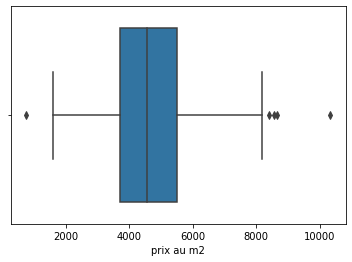

In [37]:
sns.boxplot(df["prix au m2"])

In [39]:
filtre = (df["code postal"] == "Rennes (35000)") & (df["pieces"] == 1)


df_filtre = df[filtre]
df_filtre.head()

,price,surface,pieces,types,code postal,prix au m2
21,185000,31,1,Appartement,Rennes (35000),5967.742
32,177650,30,1,Appartement,Rennes (35000),5921.667
43,182500,27,1,Appartement,Rennes (35000),6759.259
53,131000,21,1,Appartement,Rennes (35000),6238.095
64,127000,30,1,Appartement,Rennes (35000),4233.333


/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prix au m2'>

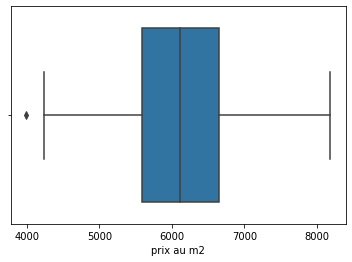

In [41]:
sns.boxplot(df_filtre["prix au m2"])

In [43]:
df_filtre.sort_values(by="price")

,price,surface,pieces,types,code postal,prix au m2
138,59000,9,1,Appartement,Rennes (35000),6555.556
139,59000,9,1,Appartement,Rennes (35000),6555.556
154,82900,15,1,Appartement,Rennes (35000),5526.667
252,103000,19,1,Appartement,Rennes (35000),5421.053
171,113184,20,1,Appartement,Rennes (35000),5659.200
208,125700,22,1,Appartement,Rennes (35000),5713.636
64,127000,30,1,Appartement,Rennes (35000),4233.333
169,131000,16,1,Appartement,Rennes (35000),8187.500
53,131000,21,1,Appartement,Rennes (35000),6238.095
123,131500,33,1,Appartement,Rennes (35000),3984.848


In [44]:
df_filtre.sort_values(by="prix au m2")

,price,surface,pieces,types,code postal,prix au m2
123,131500,33,1,Appartement,Rennes (35000),3984.848
64,127000,30,1,Appartement,Rennes (35000),4233.333
71,149000,34,1,Appartement,Rennes (35000),4382.353
255,137000,26,1,Appartement,Rennes (35000),5269.231
252,103000,19,1,Appartement,Rennes (35000),5421.053
154,82900,15,1,Appartement,Rennes (35000),5526.667
171,113184,20,1,Appartement,Rennes (35000),5659.200
208,125700,22,1,Appartement,Rennes (35000),5713.636
32,177650,30,1,Appartement,Rennes (35000),5921.667
21,185000,31,1,Appartement,Rennes (35000),5967.742
